In [52]:
!pip install underthesea

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f05d695b8d0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',)': /simple/underthesea/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f05d695b748>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',)': /simple/underthesea/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7f05d695b438>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution',)': /simple/underthesea/
  Retrying (Retry(total=1, c

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords                # stopwords are removed from text to keep just useful info
from nltk import word_tokenize, sent_tokenize

import keras
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, LSTM, SpatialDropout1D, Input, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['imdb-review-dataset', 'word2vec-nlp-tutorial']


In [54]:
# importing IMDB dataset from another source....this is done to increase our training dataset
# w/o this the max accuracy was around 88%, but using this validation set acc. increased to around 93%
df = pd.read_csv('../input/btmidtermnlp/data.csv',encoding="utf-8")
df.head(5)


,title,category,content
0,Galaxy Gear có thể điều khiển TV thông minh,Công nghệ,Mẫu đồng hồ thông minh Galaxy Gear của Samsung...
1,Nhật – Mỹ định hội đàm chớp nhoáng tại Singapo...,Thế giới,">> Phó Tổng thống Mỹ công du châu Á, bàn về Bi..."
2,Hàng ngàn học sinh miền núi Nghệ An bỏ học,Giáo dục,Hàng ngàn học sinh sau khi tốt nghiệp THCS đã ...
3,'Cô ấy bỏ em vì... em gái trượt đại học?',Đời sống,Mr Búp Bê (BB): Hay là bạn phải đến kèm cho cô...
4,Cậu bé vượt qua Face ID của iPhone ngang anh Q...,Công nghệ,Trang Wired mới đây đưa thông tin cậu bé Ammar...


In [56]:
df.shape

(51999, 3)

In [57]:
df.dropna(inplace = True)
df.shape

(51999, 3)

In [13]:
# X = df['content']
# y = df['sentiment']

In [49]:
with open("../input/vietnamesestopword/vietnamese-stopwords.txt", "r") as file:
    stopword = []
    for readline in file: 
        line_strip = readline.strip()
        stopword.append(line_strip)
stopword[0:5]

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy']

In [ ]:
lines = [i for i in df['content']]

In [ ]:
'''
Here we will do preprocessing
1. Removing punctuations
2. Lowering all words
3. removing non-alphabet things
4. removing stop words
5. Tokenizing the sentence
'''
from underthesea import word_tokenize
import string

review_lines = list()


# for line in lines:
    
#     '''
#     breaks line into it's sub parts like each word and comma etc,
#     https://pythonspot.com/tokenizing-words-and-sentences-with-nltk/
#     '''
#     tokens = word_tokenize(line)   
    
#      #convert to lower case
#     tokens = [w.lower() for w in tokens]
    
#     #remove punctuation from each word
#     # brief detail: https://pythonadventures.wordpress.com/2017/02/05/remove-punctuations-from-a-text/
#     table = str.maketrans('','', string.punctuation)
#     stripped = [w.translate(table) for w in tokens]
     
#     # remove remaining tokens that are not alphabetic
#     words = [w for w in stripped if w.isalpha()]
    
#     # filter out stop words
#     stop_words = set(stopwords.words('english'))
#     words = [w for w in words if w not in stop_words]
    
#     review_lines.append(words)

In [19]:
'''
gensim is python library for training word embeddings in given data
for more information visit: 
1. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
2. http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XEoWKVwzbIV
'''
import gensim
import multiprocessing

cores = multiprocessing.cpu_count()

embedding_vector_size = 300
# now training embeddings for each word 
model_1 = gensim.models.Word2Vec(sentences = review_lines,
                                 size=embedding_vector_size,
                                 min_count=1,
                                 window=5, 
                                 sample=6e-5,
                                 negative=20,
                                 workers=4 )

# to get total number of unique words
words = list(model_1.wv.vocab)

print("vocab size:", len(words))

vocab size: 135639


Text(0,0.5,'frequency')

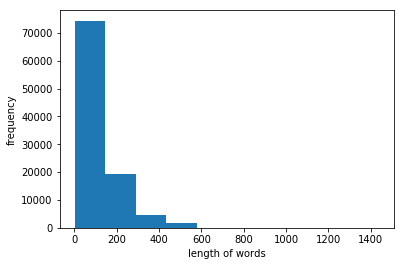

In [20]:
#len(sequence)
leng=0
length = [(leng + len(x)) for x in review_lines]
plt.hist(length)
plt.xlabel('length of words')
plt.ylabel('frequency')

In [21]:
import math
avg_length = sum(length)/len(review_lines)

# if words are more than max_length then they are skipped, if less than padding with 0 is done
print(avg_length)

122.12747


In [22]:
#max_len = math.ceil(avg_length)             # this is used to decide how man words in seq to keep
max_len = math.ceil(avg_length) 

In [23]:
'''
Now we have trained the embeddings, we now have embedding vector for each word. We will
convert our text training data to numeric using theseword embeddings.
First, we need to make length of each input same, therefore we'll do padding. But padding happends 
on numeric data, therefore we'll convert texts to sequences using tokenize() function. Then add padding
Then we'll replace each non-zero numeric resulted from texts to sequences to its corresponding word
embedding.
'''
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)       #keeps 6000 most common words
train_test_data = review_lines                       # contains word tokens extracted from lines
tokenizer.fit_on_texts(train_test_data)
sequence = tokenizer.texts_to_sequences(train_test_data)
train_test_data = pad_sequences(sequence, maxlen = max_len)

In [24]:
# Preparing embedding matrix
vocab_size = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((vocab_size, embedding_vector_size))
# +1 is done because i starts from 1 instead of 0, and goes till len(vocab)
for  word, i in tokenizer.word_index.items():
    embedding_vector = model_1.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
X = train_test_data[:ntrain,:]
X = np.append(X,train_test_data[ntrain+25000: ,:])
X = X.reshape(-1,123)
y1 = y.append(imdb_data['sentiment'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X , y1, test_size=0.2, random_state=42, shuffle=True)

In [27]:
model = Sequential()

model.add(Embedding(input_dim = vocab_size, output_dim = embedding_vector_size, 
                    input_length = max_len, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.1)))
model.add(Dense(10))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [29]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, epochs = 30, batch_size = 700, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 123, 150)          20346000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               110080    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 20,457,381
Trainable params: 20,457,381
Non-trainable params: 0
_________________________________________________________________
None
Train on 60000 samples, validate on 15000 samples
Epoch 1/30
11900/60000 [====>.........................] - ETA: 37s - loss: 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_test_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average = 'weighted')

In [ ]:
#predicting test_data
y_pred = model.predict(train_test_data[ntrain:ntrain+25000 , :])

In [ ]:
predictions = [1 if (x>0.5) else 0 for x in y_pred ]

In [ ]:
predictions = pd.Series(predictions)

In [ ]:
ids = raw_test_data['id'].str.replace('"', '')

In [ ]:
submission = pd.DataFrame({'id': ids, 'sentiment':predictions})
submission.to_csv('word2vec.csv',index=False)